#Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Lavoriamo da immagini ottenute a partire da MNIST.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 0s 0us/step


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [4]:
my_gen = generator(x_train,5)

In [5]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


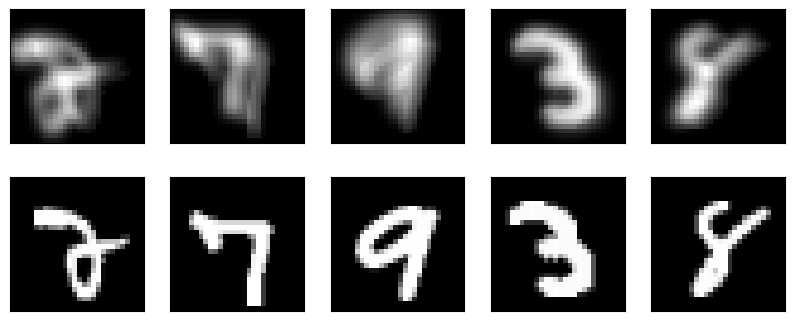

In [6]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


# Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

# Costruzione Modello
Nel processo di sviluppo del modello sono state valutate le prestazioni di diverse architetture neurali, tra cui, in versioni semplificate, modelli convoluzionali tradizionali e autoencoder. La scelta finale è ricaduta sull'architettura U-net, essendo risultata più efficace nel ricostruire le immagini sfocate rispetto ad altri modelli tesati; questa decisione è inoltre stata guidata dall'ampio utilizzo delle U-net per task simili in letteratura, seppur con l'applicazione di tecniche più sofisticate di quella usata nel modello finale.

Particolare attenzione è stata data alla scelta della profondità della rete e alla configurazione dei filtri convoluzionali, cercando di bilanciare la performance del modello con la sua complessità.

L'impiego di molteplici layer convoluzionali in ciascun livello ha permesso una cattura più efficace delle caratteristiche delle immagini, mentre l'introduzione della batch normalization ha contribuito a velocizzare il processo di apprendimento, stabilizzando il gradiente e migliorando la convergenza del modello. Queste scelte sono state guidate dai risultati ottenuti durante i test.

In [7]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

#Blocco di downsamplig della U-net
def down_block(input, filters, activation, kernel_size=(3, 3), pool_size=(2, 2)):
  conv = Conv2D(filters, kernel_size, activation=activation, padding='same')(input)
  conv = Conv2D(filters, kernel_size, activation=activation, padding='same')(conv)
  conv = layers.BatchNormalization()(conv)
  pool = MaxPooling2D(pool_size=pool_size)(conv)

  return conv, pool

#Blocco di upsampling della U-net
def up_block(input, skip, filters, activation, kernel_size=(3, 3), up_size=(2, 2)):
  up = UpSampling2D(size=up_size)(input)
  cat = concatenate([up, skip], axis=-1)
  conv = Conv2D(filters, (3, 3), activation=activation, padding='same')(cat)
  conv = Conv2D(filters, (3, 3), activation=activation, padding='same')(conv)
  conv = layers.BatchNormalization()(conv)

  return conv

def unet_model(input_shape, activation):
  input_img = Input(shape=input_shape)

  conv1, pool1 = down_block(input_img, 64, activation)

  conv2, pool2 = down_block(pool1, 128, activation)

  conv3, pool3 = down_block(pool2, 256, activation, pool_size=(7, 7))

  bottleneck = Conv2D(512, (3, 3), activation=activation, padding='same')(pool3)
  bottleneck = Conv2D(512, (3, 3), activation=activation, padding='same')(bottleneck)
  bottleneck = layers.BatchNormalization()(bottleneck)

  conv4 = up_block(bottleneck, conv3, 256, activation, up_size=(7, 7))

  conv5 = up_block(conv4, conv2, 128, activation)

  conv6 = up_block(conv5, conv1, 64, activation)

  output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv6)
  output = layers.Reshape((28, 28))(output)

  model = Model(inputs=input_img, outputs=output)
  return model


Determinare la funzione di attivazione più adatta per i layer convoluzionali del modello è stato un passo fondamentale. La funzione ReLu è stata scelta in modo sperimentale, confrontandone i risultati ottenuti nella valutazione finale con quelli dati da altre funzioni, quali tanh, ELU, swish e Leaky ReLU.

In [8]:
#aggiungi il numero di canali alla shape dell'immagine
input_shape = x_train.shape[1:] + (1,)

unet = unet_model(input_shape, 'relu')

Il modello è compilato con l'ottimizzatore Adam utilizzando i parametri di default. Per la funzione di loss, viene utilizzato il Mean Squared Error (MSE) come indicato nella consegna del progetto.

In [9]:
from keras.optimizers import Adam

unet.compile(optimizer=Adam(), loss='mse')

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d_1[0][0]']            
 Normalization)                                                                               

# Allenamento
Durante la prima fase di allenamento del modello viene utilizzata una batch size relativamente alta cercando di bilanciare la velocità di apprendimento con la stabilità dell'addestramento, questo ha consentito di aumentare il numero di epoche, permettendo così al modello di passare attraverso più iterazioni di apprendimento. Il parametro steps_per_epoch è calcolato in modo da garantire che il modello veda un numero di immagini pari alla dimensione dell'intero set di dati in ogni epoca, riducendo la possibilità di andare in
overfitting.

In [10]:
batch_size = 256

train_gen = generator(x_train, batch_size)

steps_per_epoch = len(x_train) // batch_size

history = unet.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=20
)

Epoch 1/20
234/234 [==============================] - 86s 262ms/step - loss: 0.0232
Epoch 2/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0081
Epoch 3/20
234/234 [==============================] - 61s 261ms/step - loss: 0.0052
Epoch 4/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0044
Epoch 5/20
234/234 [==============================] - 61s 263ms/step - loss: 0.0038
Epoch 6/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0035
Epoch 7/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0032
Epoch 8/20
234/234 [==============================] - 61s 260ms/step - loss: 0.0030
Epoch 9/20
234/234 [==============================] - 61s 261ms/step - loss: 0.0029
Epoch 10/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0027
Epoch 11/20
234/234 [==============================] - 61s 262ms/step - loss: 0.0027
Epoch 12/20
234/234 [==============================] - 61s 260ms/step - lo

Avendo osservato una riduzione della loss meno marcata nelle ultime epoche della fase precedente di allenamento, si è cercato di affinare ulteriormente le prestazioni del modello riducendo il learning rate e diminuendo la batch size. Questi cambiamenti hanno permesso di eseguire aggiustamenti più precisi nei pesi del modello, aumentando la probabilità di localizzare un minimo più ottimale nella funzione di loss.

In [11]:
unet.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

batch_size = 64

train_gen = generator(x_train, batch_size)

steps_per_epoch = len(x_train) // batch_size

history = unet.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs= 5
)


Epoch 1/5
937/937 [==============================] - 172s 174ms/step - loss: 0.0019
Epoch 2/5
937/937 [==============================] - 162s 173ms/step - loss: 0.0018
Epoch 3/5
937/937 [==============================] - 162s 173ms/step - loss: 0.0018
Epoch 4/5
937/937 [==============================] - 165s 177ms/step - loss: 0.0018
Epoch 5/5
937/937 [==============================] - 163s 174ms/step - loss: 0.0017


In [15]:
def compare_images(x_test, num_img, model):
  test_gen = generator(x_test, num_img)
  blurred_images, original_images = next(test_gen)

  deblurred_images = model.predict(blurred_images)

  plt.figure(figsize=(2*num_img, 6))

  for i in range(num_img):
    # Display original images
    ax = plt.subplot(3, num_img, i + 1)
    plt.imshow(original_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title("Originali")

    # Display blurred images
    ax = plt.subplot(3, num_img, i + 1 + num_img)
    plt.imshow(blurred_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title("Sfocate")

    # Display deblurred images
    ax = plt.subplot(3, num_img, i + 1 + 2 * num_img)
    plt.imshow(deblurred_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title("Ricostruite")

  plt.show()


Definisco una funzione per valutare il nostro modello di deblurring delle immagini. Questa funzione calcola l'errore quadratico medio (MSE) tra le immagini originali e quelle deblurred predette dal modello. Utilizziamo un generatore per creare un set di immagini sfocate dal test set: per ogni round di valutazione, generiamo 1000 immagini sfocate e calcoliamo l'MSE, ripetiamo questo processo per 10 round e poi calcoliamo la media e la deviazione standard dei punteggi MSE.

In [16]:
from keras.losses import MeanSquaredError

def evaluation(x_test, model):
  mse_scores = []
  for _ in range(10):
      test_gen = generator(x_test, 10000)
      blurred_images, original_images = next(test_gen)
      deblurred_images = model.predict(blurred_images)
      mse = MeanSquaredError()
      mse_scores.append(mse(original_images, deblurred_images).numpy())

  print("Average MSE:", np.mean(mse_scores))
  print("Standard deviation:", np.std(mse_scores))

Il modello viene valutato su immagini prese dal test set di MNIST. Dopo la valutazione vengono mostrate 5 immagini prese dal test set per permettere un paragone visivo tra le immagini originali, quelle sfocate e quelle ricostruite dalla rete.

313/313 [==============================] - 4s 13ms/step
Average MSE: 0.0016238171
Standard deviation: 2.3168157e-05
1/1 [==============================] - 0s 18ms/step


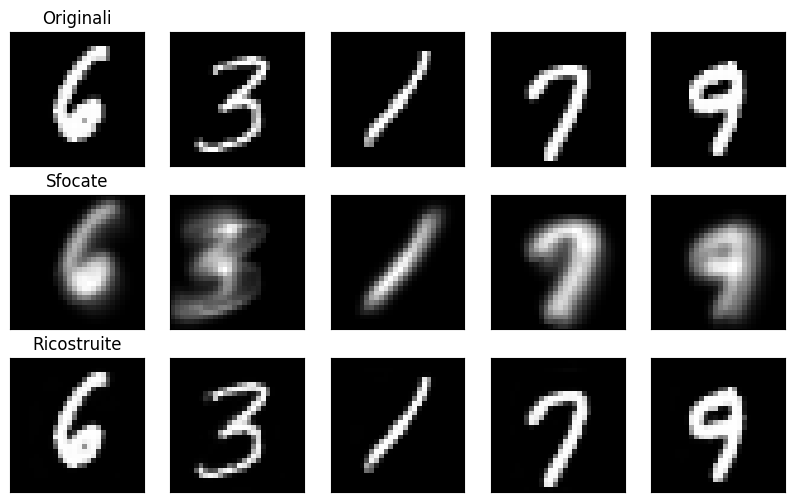

In [18]:
evaluation(x_test, unet)
compare_images(x_test, 5, unet)